In [ ]:
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.ClimoGenerator import ClimoGenerator
import yaml
import xarray as xr
import matplotlib
%matplotlib inline

In [2]:
# Read in the yaml file
diag_config_yml_path = "/glade/work/altuntas/mom6.diags/c.c2b6.CNYF.T62_t061.boundary_lateral_mixing_test.004/diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])

In [4]:
# Load the grid
grd = dcase.grid()

MOM6 grid successfully loaded... 



In [5]:
# Create the climatology instance
climo = ClimoGenerator(diag_config_yml['Climo'], dcase)

In [6]:
# Compute the climatology dataset
dset_climo = climo.stage()

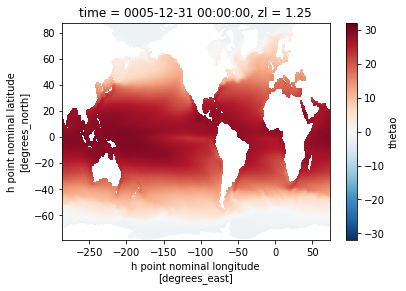

In [7]:
# Plot 5-yearly average sst
sst = dset_climo['5Y'].thetao.isel(zl=0)
sst.plot()

In [8]:
# Read in obs
phc_path = '/glade/p/cesm/omwg/obs_data/phc/'
phc_temp = xr.open_mfdataset(phc_path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc')

In [9]:
# Create a data array of sst (obs)
sst_obs = phc_temp['TEMP'].isel(depth=0)
sst_obs = sst_obs.rename({'X' : 'xh', 'Y' : 'yh'})
sst_obs['xh'].values = sst['xh'].values
sst_obs['yh'].values = sst['yh'].values

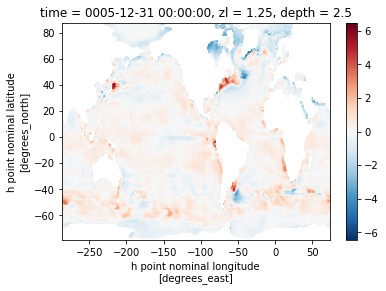

In [10]:
# Plot the bias
(sst-sst_obs).plot()